In [1]:
from sklearn.model_selection import StratifiedKFold
from sklearn import tree
from sklearn import svm
from sklearn import ensemble
from sklearn import neighbors
from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing
from sklearn import model_selection
from xgboost import XGBClassifier
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from scipy import interp
from IPython.display import Image
import matplotlib as mlp
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import seaborn as sns
from imblearn.over_sampling import SMOTE
from pygam import LogisticGAM

# Custom Python Files
from dataprep.dataPrep import cleanData
from dataprep.modelPrep import model_prep
from dataprep.modelPrep import plotROCCurve

%matplotlib inline 

### Load in data for modeling

#### Features and response for XGBoost and RandomForest

In [4]:
xcols_base = "ALL"

ycol_base = "churn"

df_base = cleanData("PSCCustomerData.csv", boxcox=True)

X_base, y_base, xcolnames_base, _, _ = model_prep(df_base,xcols_base,ycol_base)

#### Features and Response for Logistic Regression

In [11]:
seed = 1234

# Best Features
xcols = ['callsPerQuarter','associateddeals','sessionsPerDay','callcycle_numeric']

# List of interaction terms (each their own sublist)
interactionList = [ ['callsPerQuarter', 'associateddeals'],
                    ['assoccontacts', 'associateddeals'],
                    ['assoccontacts', 'MRR'],
]

termDict = {
    "callcycle_numeric" : 2 # Higher level terms desired
}


ycol = "churn"

df = cleanData("PSCCustomerData.csv", boxcox=True)

X, y, xcolnames = model_prep(df,xcols,ycol, higherTerms=True, termDict=termDict, interactionTerms=True, interactionList = interactionList, standardize=False)

### Stratified Cross Validation - Since the Response values are not balanced

In [6]:
def stratified_cv(X, y, clf_class, shuffle=True, n_folds=3, random_state=1234, **kwargs):
    stratified_k_fold = StratifiedKFold(n_splits=n_folds, shuffle=shuffle, random_state=random_state)
    y_pred = y.copy()
    # ii -> train
    # jj -> test indices
    for ii, jj in stratified_k_fold.split(X,y): 
        X_train, X_test = X[ii], X[jj]
        y_train = y[ii]
        clf = clf_class(random_state=random_state, **kwargs)
        clf.fit(X_train,y_train)
        y_pred[jj] = clf.predict(X_test)
    return y_pred

In [7]:
import warnings
warnings.filterwarnings('ignore')

print('Random Forest Classifier:      {:.2f}'.format(metrics.accuracy_score(y_base, stratified_cv(X_base, y_base, ensemble.RandomForestClassifier))))

print('Logistic Regression:           {:.2f}'.format(metrics.accuracy_score(y, stratified_cv(X, y, linear_model.LogisticRegression))))

print('XGBoost:           {:.2f}'.format(metrics.accuracy_score(y_base, stratified_cv(X_base, y_base, XGBClassifier))))

Random Forest Classifier:      0.83
Logistic Regression:           0.79
XGBoost:           0.81


### Confusion Matrices

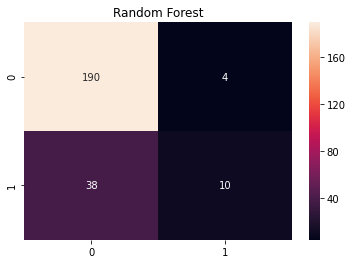

In [8]:
random_forest_conf_matrix = metrics.confusion_matrix(y_base, stratified_cv(X_base, y_base, ensemble.RandomForestClassifier))
sns.heatmap(random_forest_conf_matrix, annot=True,  fmt='');
title = 'Random Forest'
plt.title(title);

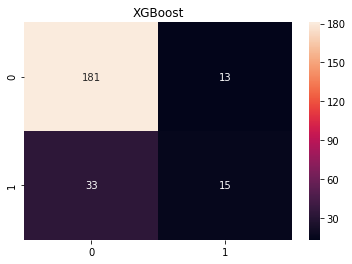

In [9]:
xgboost_reg_conf_matrix  = metrics.confusion_matrix(y_base, stratified_cv(X_base, y_base, XGBClassifier))
sns.heatmap(xgboost_reg_conf_matrix, annot=True,  fmt='');
title = 'XGBoost'
plt.title(title);

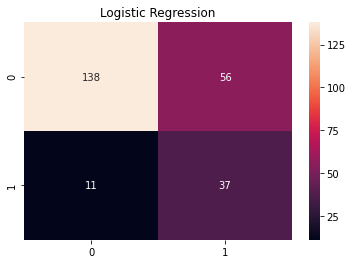

In [13]:
logistic_reg_conf_matrix  = metrics.confusion_matrix(y, stratified_cv(X, y, linear_model.LogisticRegression, class_weight='balanced', penalty='none', max_iter=10000, random_state=seed))
sns.heatmap(logistic_reg_conf_matrix, annot=True,  fmt='');
title = 'Logistic Regression'
plt.title(title);

### Classification Reports

In [14]:
print('Random Forest Classifier:\n {}\n'.format(metrics.classification_report(y_base, stratified_cv(X_base, y_base, ensemble.RandomForestClassifier, random_state=seed))))
print('XGBoost:\n {}\n'.format(metrics.classification_report(y_base, stratified_cv(X_base, y_base, XGBClassifier, random_state=seed))))

print('Logistic Regression:\n {}\n'.format(metrics.classification_report(y, stratified_cv(X, y, linear_model.LogisticRegression, class_weight='balanced', penalty='none', max_iter=10000, random_state=seed))))

Random Forest Classifier:
               precision    recall  f1-score   support

           0       0.83      0.98      0.90       194
           1       0.71      0.21      0.32        48

    accuracy                           0.83       242
   macro avg       0.77      0.59      0.61       242
weighted avg       0.81      0.83      0.79       242


XGBoost:
               precision    recall  f1-score   support

           0       0.85      0.93      0.89       194
           1       0.54      0.31      0.39        48

    accuracy                           0.81       242
   macro avg       0.69      0.62      0.64       242
weighted avg       0.78      0.81      0.79       242


Logistic Regression:
               precision    recall  f1-score   support

           0       0.93      0.71      0.80       194
           1       0.40      0.77      0.52        48

    accuracy                           0.72       242
   macro avg       0.66      0.74      0.66       242
weighted avg 

### AUC Curves

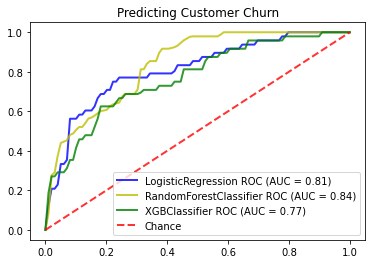

In [15]:
seed = 1234

# Plotting Setup
fig, ax = plt.subplots()

# plotROCCurve(clf_class, X, y, axis, random_state, **kwargs)

# ROC Curve Plotting
lr = linear_model.LogisticRegression
plotROCCurve(lr, X=X,y=y,axis=ax,color='b',random_state=seed,class_weight='balanced', penalty='none', max_iter=10000)

# Random Forest ROC Curve Plotting
rf = ensemble.RandomForestClassifier
plotROCCurve(rf, X_base,y_base,ax,'y',seed)

# XGBoost ROC Curve Plotting
xgb = XGBClassifier
plotROCCurve(xgb, X_base,y_base,ax,'g',seed)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Predicting Customer Churn")
ax.legend(loc="lower right")
plt.show()